# **BRAIN SCAN PREDICTION**

This dataset contains MRI brain scan images of different types of tumors: glioma, meningioma, and pituitary, along with images with no tumor.

The goal is to train a model using these images to predict whether an MRI scan shows a tumor. If a tumor is present, the model will identify its type (glioma, meningioma, or pituitary).

## **IMPORTS**

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

## **DATA PREPARATION**

In [3]:
# dataset path
dataset_path = r"D:\Projects\ML and RAG\MRI Brain Prediction\Training"

**Coverting images into Arrays and assigning labels**

In [4]:
# labels
labels_map = {
    "glioma": 0,
    "meningioma": 1,
    "notumor": 2,
    "pituitary": 3
}

# data and labels
data = []
labels = []

# Loop through each folder
for label_name, label_id in labels_map.items():
    folder_path = os.path.join(dataset_path, label_name)  
    for img_name in os.listdir(folder_path):  
        img_path = os.path.join(folder_path, img_name)  
        try:
            # Open and resize image
            img = Image.open(img_path).convert('RGB')
            img = img.resize((224, 224))  
            img_array = np.array(img) 
            
            # Append data's and labels
            data.append(img_array)
            labels.append(label_id)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Convert as arrays
data = np.array(data)
labels = np.array(labels)

print(f"Dataset size: {data.shape}, Labels size: {labels.shape}")


Dataset size: (5712, 224, 224, 3), Labels size: (5712,)


Assign the folder names and their corresponding labels, then loop through each folder to create arrays. While looping, assign the appropriate labels to each array

**Combing the data, label and making a dataframe**

In [5]:
# Flatten image 
data_flattened = data.reshape(data.shape[0], -1)  

# Combine labels
df = pd.DataFrame(data_flattened)  
df['label'] = labels 

print(df.head())
print(f"Dataset shape: {df.shape}")


   0  1  2  3  4  5  6  7  8  9  ...  150519  150520  150521  150522  150523  \
0  0  0  0  0  0  0  0  0  0  0  ...       0       0       0       0       0   
1  0  0  0  0  0  0  0  0  0  0  ...       0       0       0       0       0   
2  0  0  0  0  0  0  0  0  0  0  ...       0       0       0       0       0   
3  0  0  0  0  0  0  0  0  0  0  ...       0       0       0       0       0   
4  0  0  0  0  0  0  0  0  0  0  ...       0       0       0       0       0   

   150524  150525  150526  150527  label  
0       0       0       0       0      0  
1       0       0       0       0      0  
2       0       0       0       0      0  
3       0       0       0       0      0  
4       0       0       0       0      0  

[5 rows x 150529 columns]
Dataset shape: (5712, 150529)


**Testing ( by array to img )**

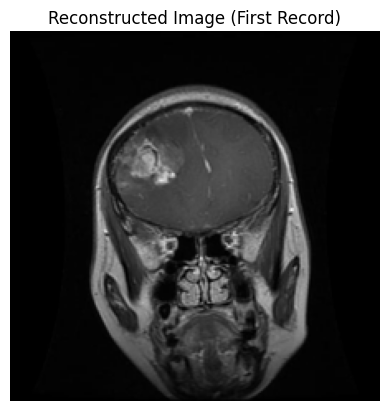

In [6]:
first_image_flattened = df.iloc[0, :-1].values  
first_image_array = first_image_flattened.reshape(224, 224, 3)  

# Convert back to image
reconstructed_image = Image.fromarray(first_image_array.astype('uint8'))

# plot
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image (First Record)")
plt.axis('off')
plt.show()

## **DATA SPLIT AND TRAINING**

**Converting images to arrays, storing in a DataFrame, and extracting X and y as numpy arrays before splitting preserves the order of images and labels**

In [7]:
# dataframe into array
data_array = df.iloc[:, :-1].values
labels_array = df['label'].values

# split
X_train, X_test, y_train, y_test = train_test_split(data_array, labels_array, test_size = 0.2, random_state=42)

print(f"Training data shape:{X_train.shape}, Validation data shape : {X_test.shape}")

Training data shape:(4569, 150528), Validation data shape : (1143, 150528)


**Reshaping the data for CNN**

In [9]:
X_train_reshaped = X_train.reshape(X_train.shape[0], 224, 224, 3)
X_test_reshaped = X_test.reshape(X_test.shape[0], 224, 224, 3)

print(f"Reshaped training data: {X_train_reshaped.shape}, Reshaped validation data: {X_test_reshaped.shape}")


Reshaped training data: (4569, 224, 224, 3), Reshaped validation data: (1143, 224, 224, 3)


**Preparing the model ( CNN Custom )**

**Used three CNN blocks with filters for more efficient training. Flattening was applied to connect the input to hidden layers, and the output layer used Softmax for multi-class classification. The model was compiled with the Adam optimizer and sparse categorical loss to minimize errors**

In [10]:
model = Sequential()

# Filters
# block one
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# block 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening 
model.add(Flatten())

# Hidden layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) 

# Output layer 
model.add(Dense(4, activation='softmax'))  

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# summary
model.summary()


C:\Users\ELCOT\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,399,044 (169.37 MB)

 Trainable params: 44,398,596 (169.37 MB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
# Train the model

training = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 3164s 19s/step - accuracy: 0.6429 - loss: 16.9926 - val_accuracy: 0.7209 - val_loss: 1.6077
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 2328s 15s/step - accuracy: 0.7342 - loss: 1.2883 - val_accuracy: 0.7708 - val_loss: 0.5424
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 2576s 18s/step - accuracy: 0.7821 - loss: 0.6962 - val_accuracy: 0.8399 - val_loss: 0.4805
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 2386s 16s/step - accuracy: 0.7887 - loss: 0.7282 - val_accuracy: 0.8635 - val_loss: 0.5084
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15710s 109s/step - accuracy: 0.7842 - loss: 0.7111 - val_accuracy: 0.8609 - val_loss: 0.4431
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 2678s 18s/step - accuracy: 0.7980 - loss: 0.7500 - val_accuracy: 0.8486 - val_loss: 0.4730
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 2123s 13s/step - accuracy: 0.8019 - loss: 0.6407 - val_accuracy: 0.8784 - val_loss: 0.3277
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1772s 12s/step - accuracy: 0.8297 - loss